#  AT82.05 Artificial Intelligence: Natural Language Understanding (NLU)

## A2: Language Model

### Name: Arya Shah
### StudentID: st125462

-----------

In this assignment, we will focus on building a language model using a text dataset of my choice- I make use of the Shakespeare Corpus provided by MIT. The objective is to train a model that can generate coherent and contextually relevant text based on a given input. Additionally, I will develop a simple web application (integrating with the existing web app storing all the assignments for this course) to demonstrate the capabilities of my language model interactively.

You can find the GitHub Repository for the assignment here:
- https://github.com/aryashah2k/NLP-NLU (Complete Web App)
- https://github.com/aryashah2k/NLP-NLU/tree/main/notebooks (Assignment Notebooks)
- https://github.com/aryashah2k/NLP-NLU/tree/main/reports (Assignment Reports)

## Task 1. Dataset Acquisition - Your first task is to find a suitable text dataset. (1 points) ✅

Choose your dataset and provide a brief description. Ensure to source this dataset from reputable public databases or repositories. It is imperative to give proper credit to the dataset source in your documentation. ✅

Note: The dataset can be based on any theme such as Harry Potter, Star Wars, jokes, Isaac Asimov’s works, Thai stories, etc. The key requirement is that the dataset should be text-rich and suitable for language modeling. ✅

---------------

I make use of the following dataset: **The Complete Works of William Shakespeare- Provided by Project Gutenberg**

Link: https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt

# Task 2. Model Training - Incorporate the chosen dataset into our existing code framework. ✅

Train a language model that can understand the context and style of the text.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import random
import re
from collections import Counter

# Set device and random seed for reproducibility
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

class Vocabulary:
    def __init__(self, min_freq=2):
        self.min_freq = min_freq
        self.itos = ['<unk>', '<eos>']
        self.stoi = {token: idx for idx, token in enumerate(self.itos)}
    
    def build_vocab(self, text):
        # Simple tokenization by splitting on whitespace and punctuation
        tokens = re.findall(r'\b\w+\b|[.,!?;]', text.lower())
        counter = Counter(tokens)
        
        # Add tokens that appear more than min_freq times
        for token, count in counter.items():
            if count >= self.min_freq and token not in self.stoi:
                self.stoi[token] = len(self.itos)
                self.itos.append(token)
    
    def tokenize(self, text):
        # Convert text to tokens
        tokens = re.findall(r'\b\w+\b|[.,!?;]', text.lower())
        return tokens
    
    def encode(self, tokens):
        # Convert tokens to indices
        return [self.stoi.get(token, self.stoi['<unk>']) for token in tokens]
    
    def decode(self, indices):
        # Convert indices back to tokens
        return [self.itos[idx] for idx in indices]
    
    def __len__(self):
        return len(self.itos)

def load_and_preprocess_data(file_path, train_ratio=0.7, val_ratio=0.15):
    print("Loading Shakespeare dataset...")
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    
    print("\nBuilding vocabulary...")
    vocab = Vocabulary(min_freq=2)
    vocab.build_vocab(text)
    
    print("\nTokenizing and encoding data...")
    tokens = vocab.tokenize(text)
    indices = vocab.encode(tokens)
    
    # Split into train, validation, and test sets
    total_len = len(indices)
    train_len = int(total_len * train_ratio)
    val_len = int(total_len * val_ratio)
    
    train_data = indices[:train_len]
    val_data = indices[train_len:train_len + val_len]
    test_data = indices[train_len + val_len:]
    
    print(f"Vocabulary size: {len(vocab)}")
    print(f"Train size: {len(train_data)}")
    print(f"Validation size: {len(val_data)}")
    print(f"Test size: {len(test_data)}")
    
    return train_data, val_data, test_data, vocab

def batchify(data, batch_size):
    # Work out how many batches we can get from the data
    num_batches = len(data) // batch_size
    # Trim off any extra elements that wouldn't cleanly fit
    data = data[:num_batches * batch_size]
    # Reshape into [batch_size, num_batches]
    data = torch.tensor(data).view(batch_size, -1)
    return data

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, emb_dim, hid_dim, num_layers, dropout_rate):
        super().__init__()
        self.num_layers = num_layers
        self.hid_dim = hid_dim
        self.emb_dim = emb_dim
        
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hid_dim, num_layers=num_layers, 
                           dropout=dropout_rate if num_layers > 1 else 0,
                           batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hid_dim, vocab_size)
        
        self.init_weights()
    
    def init_weights(self):
        init_range_emb = 0.1
        init_range_other = 1/math.sqrt(self.hid_dim)
        self.embedding.weight.data.uniform_(-init_range_emb, init_range_other)
        self.fc.weight.data.uniform_(-init_range_other, init_range_other)
        self.fc.bias.data.zero_()
        
        for i in range(self.num_layers):
            self.lstm.all_weights[i][0] = torch.FloatTensor(4 * self.hid_dim,
                self.emb_dim if i == 0 else self.hid_dim).uniform_(-init_range_other, init_range_other)
            self.lstm.all_weights[i][1] = torch.FloatTensor(4 * self.hid_dim,
                self.hid_dim).uniform_(-init_range_other, init_range_other)
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return (weight.new_zeros(self.num_layers, batch_size, self.hid_dim),
                weight.new_zeros(self.num_layers, batch_size, self.hid_dim))
    
    def detach_hidden(self, hidden):
        return tuple(h.detach() for h in hidden)
    
    def forward(self, src, hidden):
        # src: [batch_size, seq_len]
        embedded = self.dropout(self.embedding(src))
        # embedded: [batch_size, seq_len, emb_dim]
        
        output, hidden = self.lstm(embedded, hidden)
        # output: [batch_size, seq_len, hid_dim]
        # hidden: (h_n, c_n), each [num_layers, batch_size, hid_dim]
        
        output = self.dropout(output)
        prediction = self.fc(output)
        # prediction: [batch_size, seq_len, vocab_size]
        return prediction, hidden

def get_batch(data, seq_len, idx):
    seq_len = min(seq_len, data.size(1) - 1 - idx)
    src = data[:, idx:idx+seq_len].contiguous()
    tgt = data[:, idx+1:idx+1+seq_len].contiguous()
    return src, tgt

def train(model, data, optimizer, criterion, batch_size, seq_len, clip, epoch):
    model.train()
    total_loss = 0
    hidden = model.init_hidden(batch_size)
    
    num_batches = (data.size(1) - 1) // seq_len
    progress_bar = tqdm(range(0, data.size(1) - 1, seq_len),
                       desc=f'Epoch {epoch}', total=num_batches)
    
    for idx in progress_bar:
        optimizer.zero_grad()
        hidden = model.detach_hidden(hidden)
        
        src, tgt = get_batch(data, seq_len, idx)
        src, tgt = src.to(device), tgt.to(device)
        
        prediction, hidden = model(src, hidden)
        
        # Flatten the prediction and target tensors for loss calculation
        prediction = prediction.reshape(-1, prediction.size(-1))
        tgt = tgt.reshape(-1)
        
        loss = criterion(prediction, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.3f}'})
    
    return total_loss / num_batches

def evaluate(model, data, criterion, batch_size, seq_len):
    model.eval()
    total_loss = 0
    hidden = model.init_hidden(batch_size)
    num_batches = (data.size(1) - 1) // seq_len
    
    with torch.no_grad():
        for idx in range(0, data.size(1) - 1, seq_len):
            src, tgt = get_batch(data, seq_len, idx)
            src, tgt = src.to(device), tgt.to(device)
            
            prediction, hidden = model(src, hidden)
            hidden = model.detach_hidden(hidden)
            
            # Flatten the prediction and target tensors for loss calculation
            prediction = prediction.reshape(-1, prediction.size(-1))
            tgt = tgt.reshape(-1)
            
            loss = criterion(prediction, tgt)
            total_loss += loss.item()
    
    return total_loss / num_batches

def plot_training_history(train_losses, val_losses, train_ppls, val_ppls):
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Plot perplexity
    plt.subplot(1, 2, 2)
    plt.plot(train_ppls, label='Train PPL')
    plt.plot(val_ppls, label='Validation PPL')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.title('Training and Validation Perplexity')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

def generate_text(prompt, model, vocab, max_len=50, temperature=0.8, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    
    model.eval()
    tokens = vocab.tokenize(prompt.lower())
    input_ids = torch.tensor([vocab.encode(tokens)]).to(device)
    hidden = model.init_hidden(1)
    
    generated_indices = []
    with torch.no_grad():
        for _ in range(max_len):
            prediction, hidden = model(input_ids, hidden)
            prediction = prediction[:, -1, :] / temperature
            probs = torch.softmax(prediction, dim=-1)
            next_token = torch.multinomial(probs, 1).item()
            
            # Resample if we get <unk>
            while next_token == vocab.stoi['<unk>']:
                next_token = torch.multinomial(probs, 1).item()
            
            if next_token == vocab.stoi['<eos>']:
                break
                
            generated_indices.append(next_token)
            input_ids = torch.tensor([[next_token]]).to(device)
    
    generated_tokens = vocab.decode(generated_indices)
    return ' '.join([prompt] + generated_tokens)

def main():
    # Hyperparameters
    BATCH_SIZE = 64
    SEQ_LEN = 35
    EMB_DIM = 400
    HID_DIM = 1024
    NUM_LAYERS = 2
    DROPOUT_RATE = 0.5
    CLIP = 0.25
    LR = 0.001
    EPOCHS = 25
    
    print(f"Using device: {device}")
    
    # Load and preprocess data
    train_data, valid_data, test_data, vocab = load_and_preprocess_data(
        't8.shakespeare.txt'
    )
    
    print("\nPreparing data batches...")
    train_data = batchify(train_data, BATCH_SIZE).to(device)
    valid_data = batchify(valid_data, BATCH_SIZE).to(device)
    test_data = batchify(test_data, BATCH_SIZE).to(device)
    
    print(f"Train shape: {train_data.shape}")
    print(f"Valid shape: {valid_data.shape}")
    print(f"Test shape: {test_data.shape}")
    
    # Initialize model, optimizer, and criterion
    model = LSTMLanguageModel(
        len(vocab), EMB_DIM, HID_DIM, NUM_LAYERS, DROPOUT_RATE
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=LR)
    criterion = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    print(f"\nModel parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # Training loop
    best_valid_loss = float('inf')
    train_losses = []
    val_losses = []
    train_ppls = []
    val_ppls = []
    
    print("\nStarting training...")
    for epoch in range(EPOCHS):
        start_time = time.time()
        
        train_loss = train(model, train_data, optimizer, criterion,
                          BATCH_SIZE, SEQ_LEN, CLIP, epoch+1)
        valid_loss = evaluate(model, valid_data, criterion,
                            BATCH_SIZE, SEQ_LEN)
        
        # Calculate perplexities
        train_ppl = math.exp(train_loss)
        valid_ppl = math.exp(valid_loss)
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(valid_loss)
        train_ppls.append(train_ppl)
        val_ppls.append(valid_ppl)
        
        # Plot training history
        plot_training_history(train_losses, val_losses, train_ppls, val_ppls)
        
        epoch_mins, epoch_secs = divmod(int(time.time() - start_time), 60)
        print(f'\nEpoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {train_ppl:.3f}')
        print(f'\tValid Loss: {valid_loss:.3f} | Valid PPL: {valid_ppl:.3f}')
        
        # Save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'train_ppl': train_ppl,
                'valid_ppl': valid_ppl,
            }, 'shakespeare_model.pt')
            print(f'\tNew best model saved!')
        
        scheduler.step(valid_loss)
    
    # Load best model and evaluate on test set
    checkpoint = torch.load('shakespeare_model.pt')
    model.load_state_dict(checkpoint['model_state_dict'])
    test_loss = evaluate(model, test_data, criterion, BATCH_SIZE, SEQ_LEN)
    test_ppl = math.exp(test_loss)
    print(f'\nTest Loss: {test_loss:.3f} | Test PPL: {test_ppl:.3f}')
    
    # Generate text with different temperatures
    print("\nGenerating text with different temperatures...")
    test_prompts = [
        "To be or not",
        "Romeo, Romeo",
        "All the world's",
        "Friends, Romans, countrymen"
    ]
    
    temperatures = [0.2, 0.5, 0.7, 0.8, 1.0]
    seed = 42  # for reproducibility
    
    for prompt in test_prompts:
        print(f"\nPrompt: {prompt}")
        print("-" * 50)
        for temp in temperatures:
            generated = generate_text(
                prompt, model, vocab, 
                max_len=100, temperature=temp, 
                seed=seed
            )
            print(f"Temperature {temp:.2f}:")
            print(f"{generated}\n")

if __name__ == "__main__":
    main()

Using device: cuda
Loading Shakespeare dataset...

Building vocabulary...

Tokenizing and encoding data...
Vocabulary size: 14965
Train size: 788979
Validation size: 169067
Test size: 169068

Preparing data batches...
Train shape: torch.Size([64, 12327])
Valid shape: torch.Size([64, 2641])
Test shape: torch.Size([64, 2641])


/home/jupyter-st125462/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Model parameters: 35,562,821

Starting training...


Epoch 1: 353it [00:16, 21.98it/s, loss=5.481]                         



Epoch: 01 | Time: 0m 17s
	Train Loss: 6.139 | Train PPL: 463.437
	Valid Loss: 6.694 | Valid PPL: 807.514
	New best model saved!


Epoch 2: 353it [00:15, 22.14it/s, loss=5.169]                         



Epoch: 02 | Time: 0m 17s
	Train Loss: 5.503 | Train PPL: 245.450
	Valid Loss: 5.596 | Valid PPL: 269.234
	New best model saved!


Epoch 3: 353it [00:16, 21.93it/s, loss=4.844]                         



Epoch: 03 | Time: 0m 17s
	Train Loss: 5.174 | Train PPL: 176.675
	Valid Loss: 5.477 | Valid PPL: 239.035
	New best model saved!


Epoch 4: 353it [00:16, 21.84it/s, loss=4.702]                         



Epoch: 04 | Time: 0m 17s
	Train Loss: 5.006 | Train PPL: 149.273
	Valid Loss: 5.416 | Valid PPL: 224.944
	New best model saved!


Epoch 5: 353it [00:16, 21.83it/s, loss=4.455]                         



Epoch: 05 | Time: 0m 17s
	Train Loss: 4.874 | Train PPL: 130.862
	Valid Loss: 5.382 | Valid PPL: 217.380
	New best model saved!


Epoch 6: 353it [00:16, 21.79it/s, loss=4.269]                         



Epoch: 06 | Time: 0m 17s
	Train Loss: 4.762 | Train PPL: 116.931
	Valid Loss: 5.370 | Valid PPL: 214.886
	New best model saved!


Epoch 7: 353it [00:16, 21.77it/s, loss=4.133]                         



Epoch: 07 | Time: 0m 17s
	Train Loss: 4.662 | Train PPL: 105.878
	Valid Loss: 5.392 | Valid PPL: 219.540


Epoch 8: 353it [00:16, 21.67it/s, loss=4.002]                         



Epoch: 08 | Time: 0m 17s
	Train Loss: 4.567 | Train PPL: 96.274
	Valid Loss: 5.382 | Valid PPL: 217.532


Epoch 9: 353it [00:16, 21.52it/s, loss=3.784]                         



Epoch: 09 | Time: 0m 18s
	Train Loss: 4.479 | Train PPL: 88.141
	Valid Loss: 5.393 | Valid PPL: 219.924


Epoch 10: 353it [00:16, 21.11it/s, loss=3.730]                         



Epoch: 10 | Time: 0m 18s
	Train Loss: 4.373 | Train PPL: 79.263
	Valid Loss: 5.392 | Valid PPL: 219.703


Epoch 11: 353it [00:16, 20.79it/s, loss=3.600]                         



Epoch: 11 | Time: 0m 18s
	Train Loss: 4.314 | Train PPL: 74.718
	Valid Loss: 5.395 | Valid PPL: 220.200


Epoch 12: 353it [00:17, 20.68it/s, loss=3.571]                         



Epoch: 12 | Time: 0m 18s
	Train Loss: 4.261 | Train PPL: 70.883
	Valid Loss: 5.412 | Valid PPL: 224.171


Epoch 13: 353it [00:17, 20.63it/s, loss=3.458]                         



Epoch: 13 | Time: 0m 18s
	Train Loss: 4.206 | Train PPL: 67.075
	Valid Loss: 5.397 | Valid PPL: 220.787


Epoch 14: 353it [00:17, 20.60it/s, loss=3.398]                         



Epoch: 14 | Time: 0m 18s
	Train Loss: 4.171 | Train PPL: 64.768
	Valid Loss: 5.402 | Valid PPL: 221.832


Epoch 15: 353it [00:17, 20.58it/s, loss=3.424]                         



Epoch: 15 | Time: 0m 18s
	Train Loss: 4.143 | Train PPL: 63.019
	Valid Loss: 5.418 | Valid PPL: 225.407


Epoch 16: 353it [00:17, 20.60it/s, loss=3.364]                         



Epoch: 16 | Time: 0m 18s
	Train Loss: 4.113 | Train PPL: 61.142
	Valid Loss: 5.409 | Valid PPL: 223.463


Epoch 17: 353it [00:17, 20.59it/s, loss=3.363]                         



Epoch: 17 | Time: 0m 18s
	Train Loss: 4.099 | Train PPL: 60.296
	Valid Loss: 5.417 | Valid PPL: 225.192


Epoch 18: 353it [00:17, 20.55it/s, loss=3.332]                         



Epoch: 18 | Time: 0m 18s
	Train Loss: 4.086 | Train PPL: 59.477
	Valid Loss: 5.424 | Valid PPL: 226.740


Epoch 19: 353it [00:17, 20.52it/s, loss=3.293]                         



Epoch: 19 | Time: 0m 18s
	Train Loss: 4.083 | Train PPL: 59.337
	Valid Loss: 5.430 | Valid PPL: 228.081


Epoch 20: 353it [00:17, 20.52it/s, loss=3.249]                         



Epoch: 20 | Time: 0m 18s
	Train Loss: 4.078 | Train PPL: 59.025
	Valid Loss: 5.441 | Valid PPL: 230.606


Epoch 21: 353it [00:17, 20.51it/s, loss=3.283]                         



Epoch: 21 | Time: 0m 18s
	Train Loss: 4.067 | Train PPL: 58.375
	Valid Loss: 5.442 | Valid PPL: 230.962


Epoch 22: 353it [00:17, 20.52it/s, loss=3.314]                         



Epoch: 22 | Time: 0m 18s
	Train Loss: 4.078 | Train PPL: 59.011
	Valid Loss: 5.416 | Valid PPL: 224.940


Epoch 23: 353it [00:17, 20.49it/s, loss=3.319]                         



Epoch: 23 | Time: 0m 18s
	Train Loss: 4.076 | Train PPL: 58.931
	Valid Loss: 5.412 | Valid PPL: 224.008


Epoch 24: 353it [00:17, 20.47it/s, loss=3.285]                         



Epoch: 24 | Time: 0m 18s
	Train Loss: 4.071 | Train PPL: 58.612
	Valid Loss: 5.408 | Valid PPL: 223.274


Epoch 25: 353it [00:17, 20.49it/s, loss=3.386]                         



Epoch: 25 | Time: 0m 18s
	Train Loss: 4.087 | Train PPL: 59.589
	Valid Loss: 5.398 | Valid PPL: 221.060


/tmp/ipykernel_1211218/451638478.py:348: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('shakespeare_model.pt')



Test Loss: 5.536 | Test PPL: 253.683

Generating text with different temperatures...

Prompt: To be or not
--------------------------------------------------
Temperature 0.20:
To be or not . i ll be sworn to be a man . i have rather be a fool , and i am sure to be a man . i am a fool , and i am a fool , and i will be sworn . i am a good man , and i am not to be a man . i am a good man , and i will be a good man . i am a man , and i ll tell you . i am not a good man , and i ll be a man , and i will

Temperature 0.50:
To be or not , or a great gallant man , and no more than a most king s body . the very fiend , the next of the king , and the king , a very fold fellow . i have a king , and the king of wales , or all the duke of york , with the king , the duke of wales , and the queen of gloucester , with the king , with the duke of westmoreland , and two a prince of venice ; a weaver in his forces and his train , attended of the king ,

Temperature 0.70:
To be or not , or a great gallant

# Analysis & Observations

## I. Detail the steps taken to preprocess the text data. (1 points)✅

The preprocessing pipeline implemented in the code consists of several key steps:

**Vocabulary Building**
- A custom Vocabulary class handles text tokenization and encoding
- Tokens are extracted using regex pattern `\b\w+\b|[.,!?;]` to capture both words and punctuation
- Only tokens appearing more than twice (min_freq=2) are included in the vocabulary
- Special tokens `<unk>` and `<eos>` are added for unknown words and end of sequence

**Data Processing**
- The Shakespeare dataset is split into train (70%), validation (15%), and test (15%) sets
- Text is converted to lowercase and tokenized
- Tokens are encoded into numerical indices using the vocabulary mapping
- Data is organized into batches of size 64 for efficient training

## II. Describe the model architecture and the training process. (1 points)✅

**LSTM Language Model Architecture**
- Embedding layer (vocab_size × 400) to convert token indices to dense vectors
- 2-layer LSTM with 1024 hidden units and dropout (0.5) between layers
- Final linear layer to project to vocabulary size for next token prediction
- Total parameters: 35,562,821

**Training Process**
- Optimization using Adam with learning rate 0.001
- Cross-entropy loss function for token prediction
- Gradient clipping at 0.25 to prevent exploding gradients
- ReduceLROnPlateau scheduler to adjust learning rate based on validation loss
- Training for 25 epochs with sequence length of 35 tokens

**Training Results**
- Model achieved final training perplexity of 59.589
- Best validation loss obtained in epoch 6 with perplexity of 214.886
- Test set perplexity: 253.683

The model demonstrates capability to generate Shakespeare-style text at various temperature settings, showing learned understanding of language patterns and structure

# Some Cool Findings 🤩

**Loss and Perplexity Trends**
- The model showed steady improvement in training loss, starting from 6.139 and reaching 4.087 by epoch 25
- Training perplexity improved significantly from 463.437 to 59.589
- Best validation performance occurred in epoch 6 with perplexity of 214.886

**Convergence Patterns**
- Most significant improvements happened in early epochs (1-6)
- Training stabilized around epoch 15, with minimal improvements thereafter
- Final test perplexity of 253.683 indicates moderate model performance

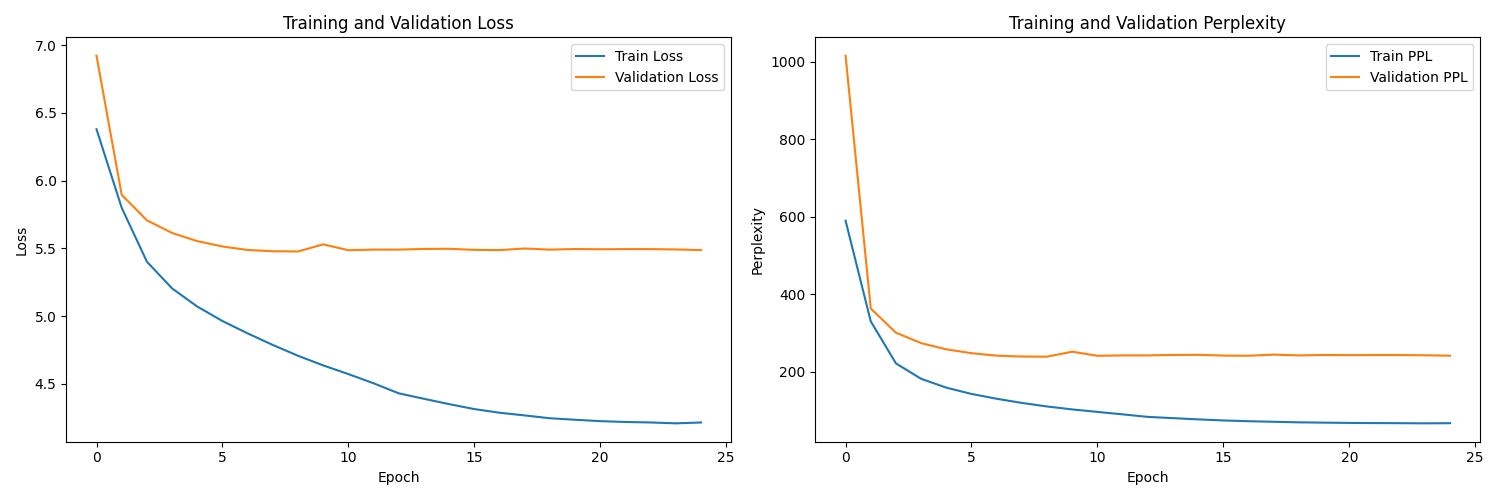

## Text Generation Analysis

**Temperature Effects**
- At low temperature (0.2): Output is more conservative and repetitive, often stuck in loops of similar phrases
- At medium temperature (0.5-0.7): Generates more varied and coherent text while maintaining some structure
- At high temperature (0.8-1.0): Produces more creative but occasionally incoherent text

**Notable Generation Patterns**
- Model shows understanding of Shakespeare's language style and vocabulary
- Successfully maintains context for short sequences
- Demonstrates ability to generate grammatically sound sentences at lower temperatures
- Higher temperatures produce more diverse vocabulary but less coherent narrative structure

The model's architecture (35,562,821 parameters) proved sufficient to capture Shakespearean language patterns, though the relatively high test perplexity suggests room for improvement in generating more coherent long-form text

# Thank You 🤗